<a href="https://colab.research.google.com/github/AndrewNewton13/Learning/blob/main/SkimLit_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the Dataset

Download the PubMed 200k RCT dataset.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@"
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

# Preprocessing the Data

In [ ]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list. 

  Args: 
    filename: a string containing the target filepath
  
  Returns:
    A list of strings with one string per line from the target filename. 
  """
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines from the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

 Let's think about how we want the data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity',
  'total_lines': 11},
  ...]
```







Writing a function that turns each of the datasetes into the format shown above.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  '''
  input_lines = get_lines(filename) # get all lines from file name
  abstract_lines = "" # create empty abstract
  abstract_samples = [] # create empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check if new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines in target abstract
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't met, the line contains a labeled sentence
      abstract_lines += line
    
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time 
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 563 ms, sys: 115 ms, total: 678 ms
Wall time: 678 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
# Turn the list of dictionries into a DataFrame
import pandas as pd 
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [ ]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

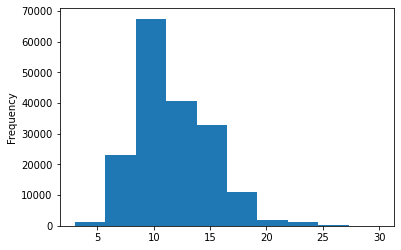

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

# Get list of sentences


In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
print(len(train_sentences), len(val_sentences), len(test_sentences))

180040 30212 30135


In [ ]:
# View the 10 lines of train sentneces
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# Make Numeric Labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

# Label Encode Labels

In [ ]:
# Extract labels and encode them into intergers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0: Create Baseline Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
# Create a pipeline
model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('clf',MultinomialNB())
])

# Fit pipeline to training data
model_0.fit(train_sentences,train_labels_encoded)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Evaluate baseline model on validation dataset
model_0_results = model_0.score(X=val_sentences,
                 y=val_labels_encoded)
model_0_results

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
baseline_results = print(classification_report(val_labels_encoded,baseline_preds))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56      3449
           1       0.65      0.59      0.61      4582
           2       0.72      0.87      0.79      9964
           3       0.75      0.14      0.23      2376
           4       0.76      0.86      0.81      9841

    accuracy                           0.72     30212
   macro avg       0.71      0.59      0.60     30212
weighted avg       0.72      0.72      0.70     30212



# Build TextVectorizer Layer for Deep Learning 

In [ ]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding

In [ ]:
# How long is each sentence on average? 
sentence_len = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sentence_len)
avg_sentence_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

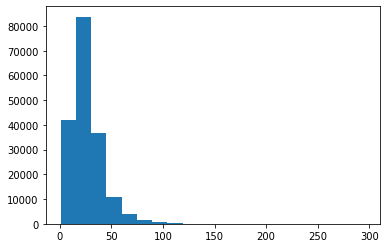

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sentence_len, bins=20)

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_length = int(np.percentile(sentence_len, 95))
output_seq_length

55

In [ ]:
# What is the max sentence length?
max(sentence_len)

296

In [ ]:
# How many words are in our vocabulary (take from table 2 in PubMed doc)
max_tokens = 68000

In [ ]:
# Create a text vectorization layer
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_mode='int',
                                    output_sequence_length=55)

In [ ]:
# Adapt the text vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the increase in the @-week frequency of sses was significantly greater for the tt group than for the pl group ( an increase of @ events vs. @ , p = @ ) .

Length of text: 34

Vectorized text: [[    2   179     5     2    89   400     4 24519    10    39   182    11
      2  2017    13    42    11     2  3769    13    26   179     4   124
     44    14     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in trainign vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

# Build Embedding Layer

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
token_embed = Embedding(input_dim=len(rct_20k_text_vocab),
                        output_dim=128,
                        mask_zero=True,
                        name='token_embedding')

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorizaion:\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 the increase in the @-week frequency of sses was significantly greater for the tt group than for the pl group ( an increase of @ events vs. @ , p = @ ) .
Sentence after vectorizaion:
 [[    2   179     5     2    89   400     4 24519    10    39   182    11
      2  2017    13    42    11     2  3769    13    26   179     4   124
     44    14     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding: 
 [[[ 0.04834253 -0.03733183 -0.01931855 ... -0.02718046  0.02321592
   -0.0155154 ]
  [ 0.03494486  0.02673164 -0.03676648 ...  0.03907999 -0.04041648
    0.00463139]
  [-0.01899519 -0.00342207 -0.01136503 ...  0.04614199  0.02589616
   -0.01755028]
  ...
  [ 0.02683849  0.02338784  0.04595051 ... -0.00565487 -0.04688434
   -0.03516044]
  [ 0.02683849  0.02338784  0.04595051 ... -0.00565487 -0.04688434
   -0.035

# Creating Datasets

Setup the data to run as fast as possible with TensorFlow tf.data API.

In [ ]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))


In [ ]:
# Take the TensorSliceDatasets and turn them into prefetch
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

# Build Conv1D Model: Model 1

In [ ]:
from tensorflow.keras import Sequential

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense output of feature vector from conv layer
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [ ]:
# Check model summary 
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 87s 103ms/step - loss: 0.9141 - accuracy: 0.6370 - val_loss: 0.6862 - val_accuracy: 0.7387
Epoch 2/3
562/562 [==============================] - 58s 102ms/step - loss: 0.6565 - accuracy: 0.7559 - val_loss: 0.6305 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 57s 101ms/step - loss: 0.6179 - accuracy: 0.7727 - val_loss: 0.5982 - val_accuracy: 0.7852


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5994 - accuracy: 0.7855


[0.5994328260421753, 0.7854825854301453]

In [ ]:
# Make predictions (it makes prediction probabilities because of softmax activation in output layer)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:5]

array([[4.3098658e-01, 1.5874425e-01, 6.2458441e-02, 3.2640606e-01,
        2.1404674e-02],
       [4.5768580e-01, 2.7153373e-01, 1.4468778e-02, 2.4616714e-01,
        1.0144572e-02],
       [1.8312404e-01, 6.1987834e-03, 1.5161616e-03, 8.0909741e-01,
        6.3694381e-05],
       [1.2370670e-05, 4.3014370e-04, 9.8286808e-01, 1.5939902e-05,
        1.6673490e-02],
       [9.8359608e-04, 4.4566158e-02, 3.8222316e-01, 1.0149078e-03,
        5.7121217e-01]], dtype=float32)

In [ ]:
# Convert prediction probabilities into labels
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 4])>

In [ ]:
# Calculate model_1 results
from sklearn.metrics import classification_report
model_1_results = print(classification_report(val_labels_encoded,model_1_preds))

              precision    recall  f1-score   support

           0       0.63      0.51      0.57      3449
           1       0.67      0.72      0.70      4582
           2       0.86      0.88      0.87      9964
           3       0.60      0.59      0.60      2376
           4       0.85      0.87      0.86      9841

    accuracy                           0.79     30212
   macro avg       0.72      0.71      0.72     30212
weighted avg       0.78      0.79      0.78     30212



# Model 2: Feature Extraction with Pretrained Token Embeddings

Use the universal sentence encoder.

The original paper used GloVe embeddings, but we will use USE pretrained embeddings.

In [ ]:
import tensorflow_hub as hub

In [ ]:
# Download pretrained tensorflow hub USE
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
# Test out pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 however , balance-proprioceptive exercises prove to be effective more than strengthening exercises for improving lower extremity function such as walking , climbing stairs , and balance in patients with juvenile idiopathic arthritis .
Sentence after embedding:
 [-0.02358643 -0.00528784  0.05051342 -0.06175252 -0.07659715  0.05802181
 -0.03109116 -0.00254025 -0.00041089  0.05619603  0.07000066 -0.0407546
 -0.04287515  0.05144439  0.04689693  0.04574588 -0.07797149  0.00900163
 -0.01673344 -0.04425095  0.05045863  0.02614489 -0.06074272  0.03785351
  0.03761204  0.05708406  0.0120958  -0.04094352  0.0009346  -0.01739858]
Length of sentence embedding: 512


In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(5,activation='softmax')(x)
model_2 = tf.keras.Model(inputs,outputs,
                         name='model_2_USE_feature_extractor')

In [ ]:
# Compile model 2
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [ ]:
# Fit model 2 
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9169 - accuracy: 0.6489 - val_loss: 0.7961 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7691 - accuracy: 0.7018 - val_loss: 0.7549 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7520 - accuracy: 0.7120 - val_loss: 0.7379 - val_accuracy: 0.7121


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.7401 - accuracy: 0.7152


[0.7400944828987122, 0.7152456045150757]

In [ ]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

array([[4.0803584e-01, 3.7539732e-01, 3.1677510e-03, 2.0400234e-01,
        9.3968380e-03],
       [3.2498360e-01, 5.3342021e-01, 3.8678509e-03, 1.3413051e-01,
        3.5977787e-03],
       [2.0824471e-01, 1.5060873e-01, 1.5432861e-02, 5.8479971e-01,
        4.0914018e-02],
       [1.1930290e-02, 4.4958539e-02, 8.2049972e-01, 8.0352863e-03,
        1.1457616e-01],
       [3.3108220e-02, 2.1808542e-01, 2.6268029e-01, 1.4450053e-02,
        4.7167602e-01],
       [1.2210204e-03, 2.7477937e-03, 6.6152620e-01, 1.6944487e-04,
        3.3433554e-01],
       [2.0437099e-03, 3.9434135e-03, 6.2774086e-01, 1.2682050e-03,
        3.6500382e-01],
       [5.0035068e-03, 2.3867926e-02, 4.7807297e-01, 1.2469479e-03,
        4.9180865e-01],
       [5.6074408e-04, 7.1989056e-03, 2.2000249e-02, 9.3549240e-04,
        9.6930456e-01],
       [1.1334424e-01, 7.2667730e-01, 2.3109121e-02, 7.1659029e-02,
        6.5210290e-02]], dtype=float32)

In [ ]:
# Convert predictions into labels 
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 4, 4, 1])>

In [ ]:
# Make classification report
model_2_results = print(classification_report(val_labels_encoded,model_2_preds))

              precision    recall  f1-score   support

           0       0.61      0.40      0.49      3449
           1       0.56      0.68      0.62      4582
           2       0.79      0.79      0.79      9964
           3       0.53      0.54      0.54      2376
           4       0.79      0.80      0.80      9841

    accuracy                           0.72     30212
   macro avg       0.66      0.64      0.65     30212
weighted avg       0.72      0.72      0.71     30212



# Model 3: Conv1D with Character Embeddings

In [ ]:
# Make a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters 
split_chars(random_train_sentence)

'h o w e v e r   ,   b a l a n c e - p r o p r i o c e p t i v e   e x e r c i s e s   p r o v e   t o   b e   e f f e c t i v e   m o r e   t h a n   s t r e n g t h e n i n g   e x e r c i s e s   f o r   i m p r o v i n g   l o w e r   e x t r e m i t y   f u n c t i o n   s u c h   a s   w a l k i n g   ,   c l i m b i n g   s t a i r s   ,   a n d   b a l a n c e   i n   p a t i e n t s   w i t h   j u v e n i l e   i d i o p a t h i c   a r t h r i t i s   .'

In [ ]:
# Split sequence level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

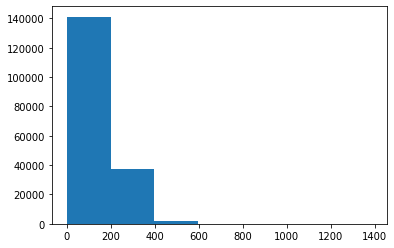

In [ ]:
# Check the distribution of sequences at char level
import matplotlib.pyplot as plt 
plt.hist(char_lens, bins=7)

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all the keyboard characters 
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, ['UNK'])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    output_mode='int',
                                    name='char_vectorizer')

In [ ]:
# Adapt the character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats 
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"Five most common characters: {char_vocab[:5]}")
print(f"Five least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
Five most common characters: ['', '[UNK]', 'e', 't', 'i']
Five least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 i n   a   m u l t i p l e   r e g r e s s i o n   m o d e l   ,   i n i t i a l   w e i g h t   l o s s   a n d   m a r i t a l   s t a t u s   w e r e   t h e   s t r o n g e s t   p r e d i c t o r s   o f   w e i g h t   l o s s   s u c c e s s   a f t e r   @ - y e a r   p e r i o d   (   r   (   @   )   =   @   ,   p   <   @   )   .

Length of random_train_chars: 135

Vectorized chars:
 [[ 4  6  5 15 16 12  3  4 14 12  2  8  2 18  8  2  9  9  4  7  6 15  7 10
   2 12  4  6  4  3  4  5 12 20  2  4 18 13  3 12  7  9  9  5  6 10 15  5
   8  4  3  5 12  9  3  5  3 16  9 20  2  8  2  3 13  2  9  3  8  7  6 18
   2  9  3 14  8  2 10  4 11  3  7  8  9  7 17 20  2  4 18 13  3 12  7  9
   9  9 16 11 11  2  9  9  5 17  3  2  8 19  2  5  8 14  2  8  4  7 10  8
  14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
# Create character level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25, # this is the size of the char embedding from the paper
                              mask_zero=True,
                              name='char_embed')

In [ ]:
# Test out character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"\nEmbedded chars, after vectorization and embedding:\n {char_embed_example}")
print(f"\nCharacter embed shape: {char_embed_example.shape}")

Charified text:
 i n   a   m u l t i p l e   r e g r e s s i o n   m o d e l   ,   i n i t i a l   w e i g h t   l o s s   a n d   m a r i t a l   s t a t u s   w e r e   t h e   s t r o n g e s t   p r e d i c t o r s   o f   w e i g h t   l o s s   s u c c e s s   a f t e r   @ - y e a r   p e r i o d   (   r   (   @   )   =   @   ,   p   <   @   )   .

Embedded chars, after vectorization and embedding:
 [[[-0.03732561 -0.00625374 -0.03624881 ... -0.03509597  0.03887546
    0.04038389]
  [-0.01630378  0.0413715   0.02987259 ... -0.00564014 -0.00382425
    0.04811371]
  [ 0.03966302 -0.00778663  0.0087173  ... -0.00448068  0.03843055
   -0.03058668]
  ...
  [ 0.03746089 -0.01602017  0.03516294 ...  0.01754716  0.00665913
    0.0185849 ]
  [ 0.03746089 -0.01602017  0.03516294 ...  0.01754716  0.00665913
    0.0185849 ]
  [ 0.03746089 -0.01602017  0.03516294 ...  0.01754716  0.00665913
    0.0185849 ]]]

Character embed shape: (1, 290, 25)


In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs,
                         outputs,
                         name='model_3_conv1d_char_embeddings')

In [ ]:
# Compile the model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [ ]:
# Check model summary
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
__________________________________

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit model 3 
history_model_3 = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2547 - accuracy: 0.4786 - val_loss: 1.0619 - val_accuracy: 0.5728
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0238 - accuracy: 0.5899 - val_loss: 0.9438 - val_accuracy: 0.6237
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.9354 - accuracy: 0.6307 - val_loss: 0.8688 - val_accuracy: 0.6589


In [ ]:
# Make predictions with char model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs[:5]

array([[0.15816839, 0.38885054, 0.10028796, 0.30771977, 0.0449733 ],
       [0.09884387, 0.70158964, 0.01760424, 0.1395348 , 0.0424275 ],
       [0.13946456, 0.2803098 , 0.12851189, 0.39248076, 0.0592331 ],
       [0.01122172, 0.02046418, 0.91530377, 0.02096826, 0.032042  ],
       [0.03050031, 0.18390068, 0.4258336 , 0.03385459, 0.3259108 ]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 1, 3, 2, 2])>

In [ ]:
# Calculate results
model_3_results = print(classification_report(val_labels_encoded,model_3_preds))

              precision    recall  f1-score   support

           0       0.48      0.25      0.33      3449
           1       0.48      0.50      0.49      4582
           2       0.72      0.79      0.76      9964
           3       0.41      0.51      0.45      2376
           4       0.75      0.76      0.75      9841

    accuracy                           0.65     30212
   macro avg       0.57      0.56      0.56     30212
weighted avg       0.64      0.65      0.64     30212



# Model 4: Multimodal Model

1. Create a token-level embedding model
2. Create a character-level model
3. Combine the above with concatenate layer ('layers.Concatenate')
4. Build a series of output layers on top of step 3 
5. Construct a model which takes token and character sequences as inputs

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

In [ ]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-lstm shown in figure 1 of PubMed paper
char_model = tf.keras.Model(char_inputs,
                            char_bi_lstm)

In [ ]:
# 3. Concatenate token and char inputs (create hybrin token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [ ]:
# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

In [ ]:
# 5. Construct model with char and token inputs 
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
# Check model summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           input_4[0][0]                    
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

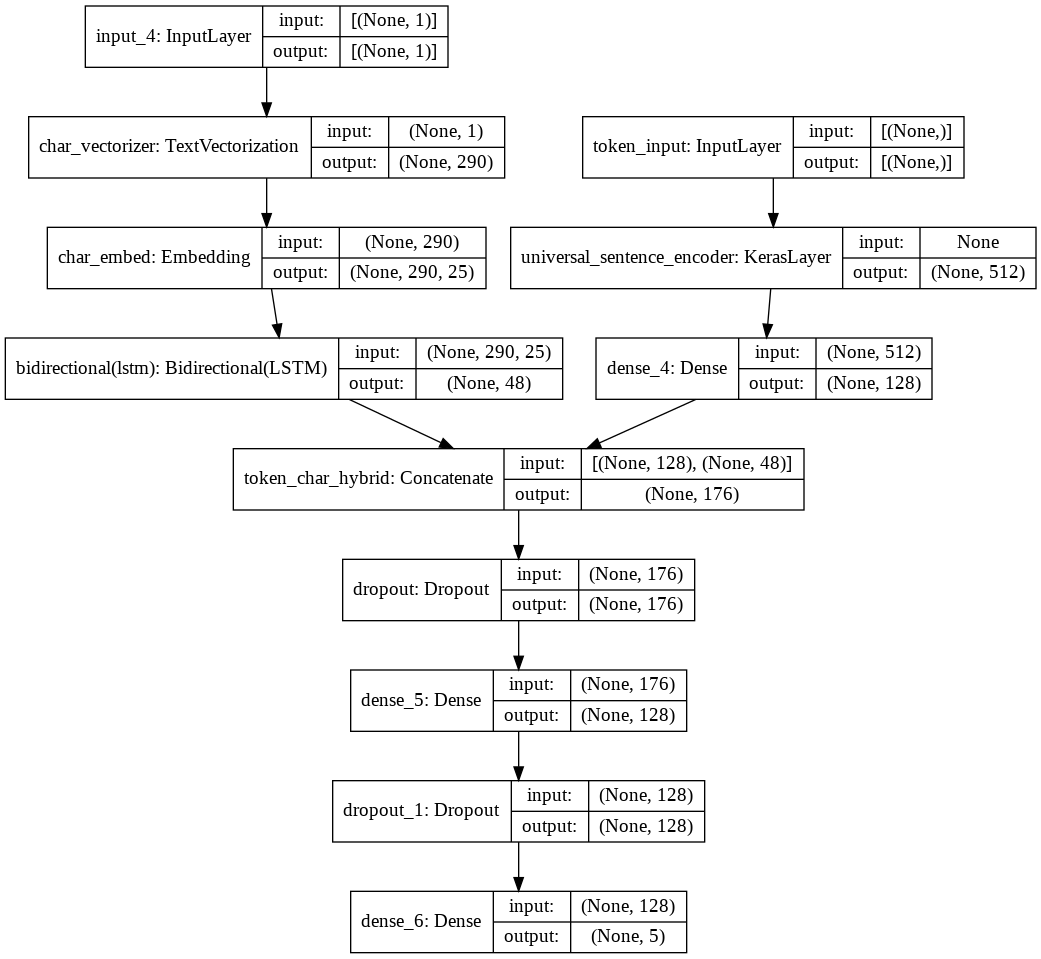

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [ ]:
# Create datasets for token and char model
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_labels))

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat above steps for validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data,val_token_char_labels))

val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_token_char_dataset, val_token_char_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [ ]:
# Fitting model on token and char level sequences
history_model_4 = model_4.fit(train_token_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_token_char_dataset)),
                              epochs=3,
                              validation_data=val_token_char_dataset,
                              validation_steps=int(0.1 * len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 83s 131ms/step - loss: 0.9806 - accuracy: 0.6103 - val_loss: 0.7781 - val_accuracy: 0.6951
Epoch 2/3
562/562 [==============================] - 71s 126ms/step - loss: 0.8029 - accuracy: 0.6896 - val_loss: 0.7231 - val_accuracy: 0.7281
Epoch 3/3
562/562 [==============================] - 68s 120ms/step - loss: 0.7752 - accuracy: 0.7042 - val_loss: 0.7010 - val_accuracy: 0.7324


In [ ]:
# Evaluate on whole validation dataset
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.6999 - accuracy: 0.7324


[0.69994056224823, 0.7323911190032959]

In [ ]:
# Make predictions
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs[:5]

array([[0.41329083, 0.3864511 , 0.00647632, 0.17987624, 0.01390553],
       [0.33587813, 0.49924234, 0.00455162, 0.15603837, 0.0042896 ],
       [0.30195177, 0.1748854 , 0.04359412, 0.43988127, 0.0396874 ],
       [0.01946592, 0.03539506, 0.78539604, 0.01146636, 0.14827658],
       [0.04428875, 0.19772138, 0.28256235, 0.01695382, 0.45847365]],
      dtype=float32)

In [ ]:
# Convert predictions into labels
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 4])>

In [ ]:
# Evaluate the results
model_4_results = print(classification_report(val_labels_encoded,model_4_preds))
model_4_results

              precision    recall  f1-score   support

           0       0.59      0.46      0.52      3449
           1       0.58      0.68      0.63      4582
           2       0.81      0.80      0.80      9964
           3       0.63      0.56      0.60      2376
           4       0.79      0.83      0.81      9841

    accuracy                           0.73     30212
   macro avg       0.68      0.67      0.67     30212
weighted avg       0.73      0.73      0.73     30212



# Model 5: Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

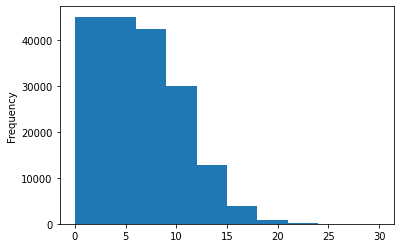

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use tensorflow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
# How many different numbers of total lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

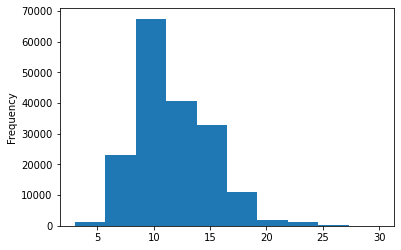

In [ ]:
# Plot the distribution of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 95)

18.0

In [ ]:
# Use tensorflow to create one hot encoded tensors of our total lines column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [ ]:
# Check the shape 
train_total_lines_one_hot[0].shape

TensorShape([20])

Building a tribrid embedding model

1. Create token level model
2. Create character level model
3. Create model for line number feature
4. Create model for total lines feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, and 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

In [ ]:
# 2. char inputs 
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

In [ ]:
# 3. line numbers model
# inputs
# dense layer 32 units with relu
line_numbers_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_numbers_inputs")
line_numbers_outputs = layers.Dense(32, activation='relu')(line_numbers_inputs)
line_numbers_model = tf.keras.Model(line_numbers_inputs, line_numbers_outputs)

In [ ]:
# 4. total lines model
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_inputs") # shape matches the depth 
total_line_outputs = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

In [ ]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embeddings")([token_model.output,
                                                                               char_model.output])

In [ ]:
# Create dropout layers
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [ ]:
# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_numbers_model.output,
                                                                                 total_line_model.output,
                                                                                 z])

In [ ]:
# 7. Create output layer 
output_layer = layers.Dense(5,activation='softmax',name="output_layer")(tribrid_embeddings)

In [ ]:
# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_numbers_model.input,total_line_model.input,token_model.input,char_model.input],
                         outputs=output_layer)

In [ ]:
# Get a summary of tribrid model
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________________________

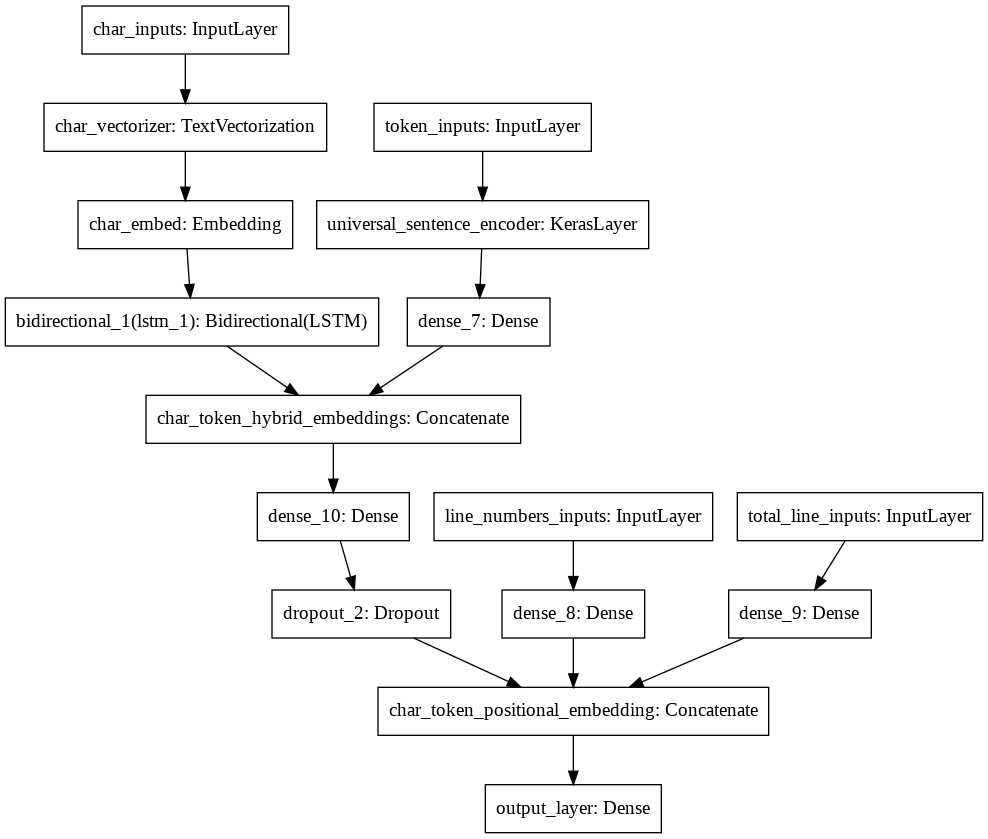

In [ ]:
# Plot model 5
tf.keras.utils.plot_model(model_5, show_shapes=False)

In [ ]:
# Compile model 5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent over fitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [ ]:
# Create tribrid embedding datasets using tf.data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                          train_total_lines_one_hot,
                                                          train_sentences,
                                                          train_chars)) # match the input order in model 5

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                          val_total_lines_one_hot,
                                                          val_sentences,
                                                          val_chars)) # match the input order in model 5
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 84s 133ms/step - loss: 1.1000 - accuracy: 0.7196 - val_loss: 0.9808 - val_accuracy: 0.8082
Epoch 2/3
562/562 [==============================] - 72s 129ms/step - loss: 0.9681 - accuracy: 0.8159 - val_loss: 0.9500 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 69s 123ms/step - loss: 0.9512 - accuracy: 0.8231 - val_loss: 0.9381 - val_accuracy: 0.8291


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs[:5]

945/945 [==============================] - 51s 50ms/step


array([[0.48986632, 0.12665477, 0.01103826, 0.35088348, 0.02155708],
       [0.5281007 , 0.09393641, 0.03947071, 0.3283834 , 0.01010873],
       [0.26421502, 0.10664   , 0.12851118, 0.424419  , 0.07621473],
       [0.0458829 , 0.0724303 , 0.68651813, 0.04688405, 0.14828467],
       [0.0495982 , 0.06166913, 0.7003892 , 0.05010163, 0.13824183]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [ ]:
# Print classification report
model_5_results = print(classification_report(val_labels_encoded, model_5_preds))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      3449
           1       0.82      0.84      0.83      4582
           2       0.88      0.88      0.88      9964
           3       0.70      0.60      0.64      2376
           4       0.86      0.88      0.87      9841

    accuracy                           0.83     30212
   macro avg       0.80      0.79      0.79     30212
weighted avg       0.83      0.83      0.83     30212



# Save and Load Model 5 

In [ ]:
# Save the best performing to SavedModel format (default)
model_5.save("skimlit_tribrid_model")

NameError: ignored

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

NameError: ignored

In [ ]:
# Evaluate the loaded model
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_model_preds = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_model_preds[:5]

In [ ]:
print(classification_report(val_labels_encoded,loaded_model_preds))

# Download and Load a Pretrained Model from Google Storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2021-08-15 11:17:28--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962957902 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 918.35M  87.7MB/s    in 11s     

2021-08-15 11:17:40 (80.8 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962957902/962957902]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
 

In [ ]:
# Load in downloaded google storage model
loaded_gs_model = tf.keras.models.load_model('skimlit_gs_model/skimlit_tribrid_model/')

# Exercise 1 - Training on 200k Samples
Train model_5 on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:

tf.keras.callbacks.ModelCheckpoint to save the model's best weights only.

tf.keras.callbacks.EarlyStopping to stop the model from training once the validation loss has stopped improving for ~3 epochs

In [ ]:
# Preprocessing the data
data_dir = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Unzip the train text
!unzip /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  


In [ ]:
train_lines_200k = get_lines(data_dir + "train.txt")
len(train_lines_200k)

2593169

In [ ]:
# Checking filenames in the directory 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
# Get data from file and preprocess it 
%%time
train_samples_200k = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples_200k = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples_200k = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples_200k), len(val_samples_200k), len(test_samples_200k))

2211861 28932 29493
CPU times: user 5.5 s, sys: 1.07 s, total: 6.57 s
Wall time: 6.69 s


In [ ]:
# Check the preprocessed data
len(train_samples_200k)

2211861

In [ ]:
import pandas as pd
# Turn the samples into DataFrames 
train_df_200k = pd.DataFrame(train_samples_200k)
val_df_200k = pd.DataFrame(val_samples_200k)
test_df_200k = pd.DataFrame(test_samples_200k)
train_df_200k.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


In [ ]:
val_df_200k.head()

,target,text,line_number,total_lines
0,BACKGROUND,adrenergic activation is thought to be an impo...,0,8
1,RESULTS,systemic venous norepinephrine was measured at...,1,8
2,RESULTS,baseline norepinephrine level was associated w...,2,8
3,RESULTS,"on multivariate analysis , baseline norepineph...",3,8
4,RESULTS,"in contrast , the relation of the change in no...",4,8


In [ ]:
train_df_200k.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

In [ ]:
train_df_200k['text'].count()

2211861

In [ ]:
train_df_200k['target'].count()

2211861

In [ ]:
# Create sentence token
train_sentences_200k = train_df_200k["text"].to_list() # train tokens
val_sentences_200k = val_df_200k["text"].tolist()
test_sentences_200k = test_df_200k["text"].tolist()
train_sentences_200k[:5], len(train_sentences_200k)

(['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  "the intervention group will participate in the online group program ` positive outlook ' .",
  'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .'],
 2211861)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# The model needs the target labels to be in numeric form
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_200k_one_hot = one_hot_encoder.fit_transform(train_df_200k["target"].to_numpy().reshape(-1,1))
val_labels_200k_one_hot = one_hot_encoder.fit_transform(val_df_200k["target"].to_numpy().reshape(-1,1))
test_labels_200k_one_hot = one_hot_encoder.fit_transform(test_df_200k["target"].to_numpy().reshape(-1,1))

# Check the training labels
train_labels_200k_one_hot[:10]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode the target labels into the one hot encoded labels
label_encoder = LabelEncoder()
train_labels_encoded_200k = label_encoder.fit_transform(train_df_200k["target"].to_numpy())
val_labels_encoded_200k = label_encoder.fit_transform(val_df_200k["target"].to_numpy())
test_labels_encoded_200k = label_encoder.fit_transform(test_df_200k["target"].to_numpy())

# Check out the encoded labels
train_labels_encoded_200k[:10]

array([0, 0, 2, 2, 2, 2, 2, 2, 2, 1])

In [ ]:
len(train_sentences_200k), len(train_labels_encoded_200k)

(2211861, 2211861)

In [ ]:
import tensorflow as tf
# Create line number token
train_line_numbers_200k_one_hot = tf.one_hot(train_df_200k["line_number"].to_numpy(),depth=15)
val_line_numbers_200k_one_hot = tf.one_hot(val_df_200k["line_number"].to_numpy(),depth=15)
test_line_numbers_200k_one_hot = tf.one_hot(test_df_200k["line_number"].to_numpy(),depth=15)

In [ ]:
train_line_numbers_200k_one_hot[0].shape

TensorShape([15])

In [ ]:
# Create total lines token
train_total_lines_200k_one_hot = tf.one_hot(train_df_200k["total_lines"].to_numpy(),depth=20)
val_total_lines_200k_one_hot = tf.one_hot(val_df_200k["total_lines"].to_numpy(),depth=20)
test_total_lines_200k_one_hot = tf.one_hot(test_df_200k["total_lines"].to_numpy(),depth=20)

In [ ]:
train_total_lines_200k_one_hot[0].shape

TensorShape([20])

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Create char tokens by splitting the sequence-level data into character-level splits
train_chars_200k = [split_chars(sentence) for sentence in train_sentences_200k]
val_chars_200k = [split_chars(sentence) for sentence in val_sentences_200k]
test_chars_200k = [split_chars(sentence) for sentence in test_sentences_200k]

In [ ]:
# Now that all the tokens have been created for the 4 inputs it's time to combine them all into a dataset
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_200k_one_hot,
                                                                train_total_lines_200k_one_hot,
                                                                train_sentences_200k,
                                                                train_chars_200k))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_200k_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset 
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_200k_one_hot,
                                                              val_total_lines_200k_one_hot,
                                                              val_sentences_200k,
                                                              val_chars_200k))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_200k_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
# Compile the model
loaded_gs_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics='accuracy')

In [ ]:
# Fit the model
history_200k_gs_model = loaded_gs_model.fit(train_pos_char_token_dataset,
                                            epochs=3,
                                            steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                                            validation_data=val_pos_char_token_dataset,
                                            validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=1),
                                                       tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints.ckpt',
                                                                                          verbose=1,
                                                                                          save_weights_only=True,
                                                                                          save_best_only=True)])

Epoch 1/3
 102/6912 [..............................] - ETA: 14:19 - loss: 0.9349 - accuracy: 0.8352

KeyboardInterrupt: ignored

# Exercise 3 - PubMed Pretrained Model


In [ ]:
# Download the model
!wget https://tfhub.dev/google/experts/bert/pubmed/2

--2021-08-15 11:24:46--  https://tfhub.dev/google/experts/bert/pubmed/2
Resolving tfhub.dev (tfhub.dev)... 74.125.203.102, 74.125.203.101, 74.125.203.100, ...
Connecting to tfhub.dev (tfhub.dev)|74.125.203.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘2.1’

2.1                     [ <=>                ]   1.18K  --.-KB/s    in 0s      

2021-08-15 11:24:47 (13.5 MB/s) - ‘2.1’ saved [1213]



In [ ]:
pretrain_model = tf.keras.models.load_model('pubmed')

OSError: ignored